# Research

## Clean data

## extract files

In [2]:
import zipfile

zip_files = ["2021.zip", "2022.zip", "2023.zip", "2024.zip"]

for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")  # Extract to current folder
    print(f"Extracted {zip_path} to current directory.")


Extracted 2021.zip to current directory.
Extracted 2022.zip to current directory.
Extracted 2023.zip to current directory.
Extracted 2024.zip to current directory.


### Clean the data to work only on the relevant parts

In [ ]:
import pandas as pd

def process_csv_files(input_files, output_files):
    # Read all CSV files into dataframes
    dataframes = [pd.read_csv(file) for file in input_files]
    
    # Find common columns in all CSV files
    common_columns = list(set(dataframes[0].columns))
    for df in dataframes[1:]:
        common_columns = list(set(common_columns) & set(df.columns))
    
    # Ensure 'ResponseId' is the first column if it exists
    if "ResponseId" in common_columns:
        common_columns.remove("ResponseId")
        common_columns.insert(0, "ResponseId")
    
    # Columns to remove
    columns_to_remove = {"SurveyEase", "Currency", "DatabaseWantToWorkWith", "NEWSOSites", 
                          "PlatformWantToWorkWith", "SOComm", "SOVisitFreq", "SurveyLength", 
                          "SOAccount", "SOPartFreq", "WebframeWantToWorkWith", "LanguageWantToWorkWith", 
                          "NEWCollabToolsWantToWorkWith", "MiscTechWantToWorkWith","LearnCode","CompTotal"
                          ,"ToolsTechWantToWorkWith"}
    common_columns = [col for col in common_columns if col not in columns_to_remove]
    
    # Keep only common columns, filter rows, and save to new CSV files
    for df, output_file in zip(dataframes, output_files):
        df = df[common_columns]
        if "ConvertedCompYearly" in df.columns:
            df = df[df["ConvertedCompYearly"].notna() & (df["ConvertedCompYearly"] != 0)]
        df.to_csv(output_file, index=False)

if __name__ == "__main__":
    input_files = ["2021/survey_results_public.csv", "2022/survey_results_public.csv",
                   "2023/survey_results_public.csv", "2024/survey_results_public.csv"]
    
    output_files = ["CleanData/filtered_2021.csv", "CleanData/filtered_2022.csv",
                    "CleanData/filtered_2023.csv", "CleanData/filtered_2024.csv"]
    
    process_csv_files(input_files, output_files)
    print("Filtered CSV files created successfully.")

## Basic Model

### 2021

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from sklearn.linear_model import LinearRegression
from collections import defaultdict


# Load Data
df = pd.read_csv('./CleanData/filtered_2021.csv', index_col='ResponseId', encoding='utf-8')

# Remove outliers using IQR method
x = 1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR
df = df[df['ConvertedCompYearly'] <= upper_bound]

# Convert to numeric
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0)

categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

# Convert each categorical column into multiple binary columns
for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column

# Feature selection: Only using YearsCodePro
X = df[['YearsCodePro']].astype(float)
y = df['ConvertedCompYearly'].astype(float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.9071
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8986
Category: DatabaseHaveWorkedWith_DynamoDB, TPR: 0.8160
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8538
Category: DatabaseHaveWorkedWith_Firebase, TPR: 0.7711
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.8684
Category: DatabaseHaveWorkedWith_MariaDB, TPR: 0.8775
Category: DatabaseHaveWorkedWith_Microsoft SQL Server, TPR: 0.8632
Category: DatabaseHaveWorkedWith_MongoDB, TPR: 0.7868
Category: DatabaseHaveWorkedWith_MySQL, TPR: 0.8106
Category: DatabaseHaveWorkedWith_Oracle, TPR: 0.8633
Category: DatabaseHaveWorkedWith_PostgreSQL, TPR: 0.8162
Category: DatabaseHaveWorkedWith_Redis, TPR: 0.8484
Category: DatabaseHaveWorkedWith_SQLite, TPR: 0.8363
Category: Employment_Employed full-time, TPR: 0.7914
Category: Employment_Employed part-time, TPR: 0.8214
Category: Employment_I prefer not to say, TPR: 0.5000
Category: Employment_Independent contractor, freelancer, or se

### 2022

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from sklearn.linear_model import LinearRegression
from collections import defaultdict


# Load Data
df = pd.read_csv('./CleanData/filtered_2022.csv', index_col='ResponseId', encoding='utf-8')

# Remove outliers using IQR method
x = 1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR
df = df[df['ConvertedCompYearly'] <= upper_bound]

# Convert to numeric
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0)

categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

# Convert each categorical column into multiple binary columns
for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column

# Feature selection: Only using YearsCodePro
X = df[['YearsCodePro']].astype(float)
y = df['ConvertedCompYearly'].astype(float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.8571
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.7697
Category: DatabaseHaveWorkedWith_CouchDB, TPR: 0.9231
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8611
Category: DatabaseHaveWorkedWith_DynamoDB, TPR: 0.8114
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8662
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.7943
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.8485
Category: DatabaseHaveWorkedWith_MariaDB, TPR: 0.8691
Category: DatabaseHaveWorkedWith_Microsoft SQL Server, TPR: 0.8746
Category: DatabaseHaveWorkedWith_MongoDB, TPR: 0.7826
Category: DatabaseHaveWorkedWith_MySQL, TPR: 0.8420
Category: DatabaseHaveWorkedWith_Neo4j, TPR: 0.8873
Category: DatabaseHaveWorkedWith_Oracle, TPR: 0.8275
Category: DatabaseHaveWorkedWith_PostgreSQL, TPR: 0.8230
Category: DatabaseHaveWorkedWith_Redis, TPR: 0.8526
Category: DatabaseHaveWorkedWith_SQLite, TPR: 0.8479
Category: Employment_Employed, full-

### 2023

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from sklearn.linear_model import LinearRegression
from collections import defaultdict


# Load Data
df = pd.read_csv('./CleanData/filtered_2023.csv', index_col='ResponseId', encoding='utf-8')

# Remove outliers using IQR method
x = 1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR
df = df[df['ConvertedCompYearly'] <= upper_bound]

# Convert to numeric
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0)

categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

# Convert each categorical column into multiple binary columns
for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column

# Feature selection: Only using YearsCodePro
X = df[['YearsCodePro']].astype(float)
y = df['ConvertedCompYearly'].astype(float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_BigQuery, TPR: 0.8074
Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.7862
Category: DatabaseHaveWorkedWith_Clickhouse, TPR: 0.8286
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.7243
Category: DatabaseHaveWorkedWith_Cockroachdb, TPR: 0.8491
Category: DatabaseHaveWorkedWith_Cosmos DB, TPR: 0.8457
Category: DatabaseHaveWorkedWith_Couch DB, TPR: 0.8776
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8947
Category: DatabaseHaveWorkedWith_Datomic, TPR: 0.7500
Category: DatabaseHaveWorkedWith_DuckDB, TPR: 0.9189
Category: DatabaseHaveWorkedWith_Dynamodb, TPR: 0.7750
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8551
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.7718
Category: DatabaseHaveWorkedWith_Firebird, TPR: 0.9394
Category: DatabaseHaveWorkedWith_H2, TPR: 0.8905
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.8817
Category: DatabaseHaveWorkedWith_InfluxDB, TPR: 0.8784
Category: DatabaseHaveWorkedWith_Mari

### 2024

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from sklearn.linear_model import LinearRegression
from collections import defaultdict


# Load Data
df = pd.read_csv('./CleanData/filtered_2024.csv', index_col='ResponseId', encoding='utf-8')

# Remove outliers using IQR method
x = 1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR
df = df[df['ConvertedCompYearly'] <= upper_bound]

# Convert to numeric
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0)

categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

# Convert each categorical column into multiple binary columns
for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column

# Feature selection: Only using YearsCodePro
X = df[['YearsCodePro']].astype(float)
y = df['ConvertedCompYearly'].astype(float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_BigQuery, TPR: 0.8018
Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.7826
Category: DatabaseHaveWorkedWith_Clickhouse, TPR: 0.7708
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.6829
Category: DatabaseHaveWorkedWith_Cockroachdb, TPR: 0.5500
Category: DatabaseHaveWorkedWith_Cosmos DB, TPR: 0.7941
Category: DatabaseHaveWorkedWith_Couch DB, TPR: 0.8125
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8750
Category: DatabaseHaveWorkedWith_Databricks SQL, TPR: 0.7879
Category: DatabaseHaveWorkedWith_Datomic, TPR: 0.8571
Category: DatabaseHaveWorkedWith_DuckDB, TPR: 0.6774
Category: DatabaseHaveWorkedWith_Dynamodb, TPR: 0.7277
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8058
Category: DatabaseHaveWorkedWith_EventStoreDB, TPR: 0.7143
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.7424
Category: DatabaseHaveWorkedWith_Firebird, TPR: 0.8667
Category: DatabaseHaveWorkedWith_H2, TPR: 0.7108
Category: DatabaseHaveWork

## Advacned Model

### 2021

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from xgboost import XGBRegressor
from collections import defaultdict




df = pd.read_csv('./CleanData/filtered_2021.csv',index_col='ResponseId', encoding='utf-8')

x=1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

df = df[(df['ConvertedCompYearly'] <= upper_bound)]

df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0).astype(float)
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce').fillna(0).astype(float)



categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column



# Feature selection: DevType, YearsCode, EdLevel, Country

y = df['ConvertedCompYearly']
X = df.drop(columns=['ConvertedCompYearly'])


# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': np.linspace(0.005, 0.3, 15),  
    'max_depth': [3, 5, 7, 10, 12],  
    'min_child_weight': [1, 3, 5, 7],
    'subsample': np.linspace(0.5, 1.0, 6),  
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.1, 1]  
}


# Initialize the model
xgb_model = XGBRegressor(
    objective='reg:squarederror', random_state=42)



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Test 50 random combinations
    scoring='r2',             # Optimize for R-squared
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    n_jobs=6,                # Use all cores
    random_state=42           # Ensure reproducibility
)

random_search.fit(X_train,y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score from CV: {best_score:.4f}")


best_model_2021 = random_search.best_estimator_
best_model_2021.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.08928571428571429, 'gamma': 0, 'colsample_bytree': 0.6}
Best R-squared Score from CV: 0.7023


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08928571428571429,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred_best = best_model_2021.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred_best >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.9000
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.9130
Category: DatabaseHaveWorkedWith_DynamoDB, TPR: 0.9242
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8999
Category: DatabaseHaveWorkedWith_Firebase, TPR: 0.8289
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.9474
Category: DatabaseHaveWorkedWith_MariaDB, TPR: 0.8607
Category: DatabaseHaveWorkedWith_Microsoft SQL Server, TPR: 0.9066
Category: DatabaseHaveWorkedWith_MongoDB, TPR: 0.8483
Category: DatabaseHaveWorkedWith_MySQL, TPR: 0.8512
Category: DatabaseHaveWorkedWith_Oracle, TPR: 0.9112
Category: DatabaseHaveWorkedWith_PostgreSQL, TPR: 0.8958
Category: DatabaseHaveWorkedWith_Redis, TPR: 0.9005
Category: DatabaseHaveWorkedWith_SQLite, TPR: 0.8646
Category: Employment_Employed full-time, TPR: 0.8988
Category: Employment_Employed part-time, TPR: 0.5893
Category: Employment_I prefer not to say, TPR: 0.7500
Category: Employment_Independent contractor, freelancer, or se

### 2022

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from xgboost import XGBRegressor
from collections import defaultdict




df = pd.read_csv('./CleanData/filtered_2022.csv',index_col='ResponseId', encoding='utf-8')

x=1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

df = df[(df['ConvertedCompYearly'] <= upper_bound)]

df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0).astype(float)
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce').fillna(0).astype(float)



categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column



# Feature selection: DevType, YearsCode, EdLevel, Country

y = df['ConvertedCompYearly']
X = df.drop(columns=['ConvertedCompYearly'])


# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': np.linspace(0.005, 0.3, 15),  
    'max_depth': [3, 5, 7, 10, 12],  
    'min_child_weight': [1, 3, 5, 7],
    'subsample': np.linspace(0.5, 1.0, 6),  
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.1, 1]  
}


# Initialize the model
xgb_model = XGBRegressor(
    objective='reg:squarederror', random_state=42)



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Test 50 random combinations
    scoring='r2',             # Optimize for R-squared
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    n_jobs=6,                # Use all cores
    random_state=42           # Ensure reproducibility
)

random_search.fit(X_train,y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score from CV: {best_score:.4f}")


best_model_2022 = random_search.best_estimator_
best_model_2022.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.026071428571428572, 'gamma': 0, 'colsample_bytree': 0.7}
Best R-squared Score from CV: 0.6642


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.026071428571428572,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred_best = best_model_2022.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred_best >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.9011
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.7879
Category: DatabaseHaveWorkedWith_CouchDB, TPR: 0.8462
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8611
Category: DatabaseHaveWorkedWith_DynamoDB, TPR: 0.9173
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8929
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.7872
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.9091
Category: DatabaseHaveWorkedWith_MariaDB, TPR: 0.7923
Category: DatabaseHaveWorkedWith_Microsoft SQL Server, TPR: 0.8695
Category: DatabaseHaveWorkedWith_MongoDB, TPR: 0.8275
Category: DatabaseHaveWorkedWith_MySQL, TPR: 0.8219
Category: DatabaseHaveWorkedWith_Neo4j, TPR: 0.8310
Category: DatabaseHaveWorkedWith_Oracle, TPR: 0.8179
Category: DatabaseHaveWorkedWith_PostgreSQL, TPR: 0.8684
Category: DatabaseHaveWorkedWith_Redis, TPR: 0.8647
Category: DatabaseHaveWorkedWith_SQLite, TPR: 0.8573
Category: Employment_Employed, full-

### 2023

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from xgboost import XGBRegressor
from collections import defaultdict




df = pd.read_csv('./CleanData/filtered_2023.csv',index_col='ResponseId', encoding='utf-8')

x=1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

df = df[(df['ConvertedCompYearly'] <= upper_bound)]

df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0).astype(float)
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce').fillna(0).astype(float)



categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column



# Feature selection: DevType, YearsCode, EdLevel, Country

y = df['ConvertedCompYearly']
X = df.drop(columns=['ConvertedCompYearly'])


# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': np.linspace(0.005, 0.3, 15),  
    'max_depth': [3, 5, 7, 10, 12],  
    'min_child_weight': [1, 3, 5, 7],
    'subsample': np.linspace(0.5, 1.0, 6),  
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.1, 1]  
}


# Initialize the model
xgb_model = XGBRegressor(
    objective='reg:squarederror', random_state=42)



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Test 50 random combinations
    scoring='r2',             # Optimize for R-squared
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    n_jobs=6,                # Use all cores
    random_state=42           # Ensure reproducibility
)

random_search.fit(X_train,y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score from CV: {best_score:.4f}")


best_model_2023 = random_search.best_estimator_
best_model_2023.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.08928571428571429, 'gamma': 0, 'colsample_bytree': 0.6}
Best R-squared Score from CV: 0.6629


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08928571428571429,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred_best = best_model_2023.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred_best >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_BigQuery, TPR: 0.8934
Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.8966
Category: DatabaseHaveWorkedWith_Clickhouse, TPR: 0.8000
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.8486
Category: DatabaseHaveWorkedWith_Cockroachdb, TPR: 0.9245
Category: DatabaseHaveWorkedWith_Cosmos DB, TPR: 0.8883
Category: DatabaseHaveWorkedWith_Couch DB, TPR: 0.8571
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8684
Category: DatabaseHaveWorkedWith_Datomic, TPR: 0.8000
Category: DatabaseHaveWorkedWith_DuckDB, TPR: 0.9730
Category: DatabaseHaveWorkedWith_Dynamodb, TPR: 0.9393
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8864
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.8188
Category: DatabaseHaveWorkedWith_Firebird, TPR: 0.7576
Category: DatabaseHaveWorkedWith_H2, TPR: 0.8248
Category: DatabaseHaveWorkedWith_IBM DB2, TPR: 0.9032
Category: DatabaseHaveWorkedWith_InfluxDB, TPR: 0.8649
Category: DatabaseHaveWorkedWith_Mari

### 2024

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, recall_score
from xgboost import XGBRegressor
from collections import defaultdict




df = pd.read_csv('./CleanData/filtered_2024.csv',index_col='ResponseId', encoding='utf-8')

x=1.5
Q1 = df['ConvertedCompYearly'].quantile(0.25)
Q3 = df['ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + x * IQR

df = df[(df['ConvertedCompYearly'] <= upper_bound)]

df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce').fillna(0).astype(float)
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce').fillna(0).astype(float)



categorical_cols = [
    "DatabaseHaveWorkedWith", "Employment", "DevType", "ToolsTechHaveWorkedWith",
    "LanguageHaveWorkedWith", "NEWCollabToolsHaveWorkedWith", "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith", "PlatformHaveWorkedWith","Age","MainBranch","EdLevel","OrgSize","Country"
]

for col in categorical_cols:
    if col in df.columns:
        dummies = df[col].str.get_dummies(sep=';')
        dummies.columns = [f"{col}_{c}" for c in dummies.columns]  # Prefix column names
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)  # Remove original categorical column



# Feature selection: DevType, YearsCode, EdLevel, Country

y = df['ConvertedCompYearly']
X = df.drop(columns=['ConvertedCompYearly'])


# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': np.linspace(0.005, 0.3, 15),  
    'max_depth': [3, 5, 7, 10, 12],  
    'min_child_weight': [1, 3, 5, 7],
    'subsample': np.linspace(0.5, 1.0, 6),  
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_lambda': [0.1, 1, 10],  
    'reg_alpha': [0, 0.1, 1]  
}


# Initialize the model
xgb_model = XGBRegressor(
    objective='reg:squarederror', random_state=42)



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Test 50 random combinations
    scoring='r2',             # Optimize for R-squared
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    n_jobs=6,                # Use all cores
    random_state=42           # Ensure reproducibility
)

random_search.fit(X_train,y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R-squared Score from CV: {best_score:.4f}")


best_model_2024 = random_search.best_estimator_
best_model_2024.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.04714285714285714, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best R-squared Score from CV: 0.6686


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04714285714285714,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the test set
y_pred_best = best_model_2024.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_best)
rmse = root_mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Convert to binary classification for fairness evaluation
threshold = df['ConvertedCompYearly'].median()
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = pd.Series((y_pred_best >= threshold).astype(int), index=X_test.index)



# Dictionary to store TPR for each category
tpr_per_category = defaultdict(float)

# Iterate over categorical columns
for col in categorical_cols:
    unique_categories = [c for c in df.columns if col + "_" in c]  # Get one-hot encoded categories
    
    for category in unique_categories:
        # Get test samples where the category is present (1 in one-hot encoding)
        mask = X_test.index[df.loc[X_test.index, category] == 1]
        
        if len(mask) == 0:
            continue  # Skip if no samples in this category
        
        # Compute binary values for this subset
        y_test_subset = y_test_binary.loc[mask]
        y_pred_subset = y_pred_binary[mask]
        
        # Calculate TPR (Recall)
        if y_test_subset.sum() > 0:  # Only compute TPR if there are positive samples
            tpr = recall_score(y_test_subset, y_pred_subset)
        else:
            tpr = 0.0 
        tpr_per_category[category] = tpr
for category, tpr in tpr_per_category.items():
    print(f"Category: {category}, TPR: {tpr:.4f}")
mean_tpr = np.mean(list(tpr_per_category.values()))  
     
# Print results
print(f"Mean TPR: {mean_tpr:.4f}")

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Category: DatabaseHaveWorkedWith_BigQuery, TPR: 0.8829
Category: DatabaseHaveWorkedWith_Cassandra, TPR: 0.8478
Category: DatabaseHaveWorkedWith_Clickhouse, TPR: 0.8333
Category: DatabaseHaveWorkedWith_Cloud Firestore, TPR: 0.8049
Category: DatabaseHaveWorkedWith_Cockroachdb, TPR: 0.8000
Category: DatabaseHaveWorkedWith_Cosmos DB, TPR: 0.8824
Category: DatabaseHaveWorkedWith_Couch DB, TPR: 0.8125
Category: DatabaseHaveWorkedWith_Couchbase, TPR: 0.8750
Category: DatabaseHaveWorkedWith_Databricks SQL, TPR: 0.8939
Category: DatabaseHaveWorkedWith_Datomic, TPR: 1.0000
Category: DatabaseHaveWorkedWith_DuckDB, TPR: 0.9032
Category: DatabaseHaveWorkedWith_Dynamodb, TPR: 0.8750
Category: DatabaseHaveWorkedWith_Elasticsearch, TPR: 0.8261
Category: DatabaseHaveWorkedWith_EventStoreDB, TPR: 1.0000
Category: DatabaseHaveWorkedWith_Firebase Realtime Database, TPR: 0.8333
Category: DatabaseHaveWorkedWith_Firebird, TPR: 0.7333
Category: DatabaseHaveWorkedWith_H2, TPR: 0.7711
Category: DatabaseHaveWork

## Comparison between models :

### comparing accuracy metrics

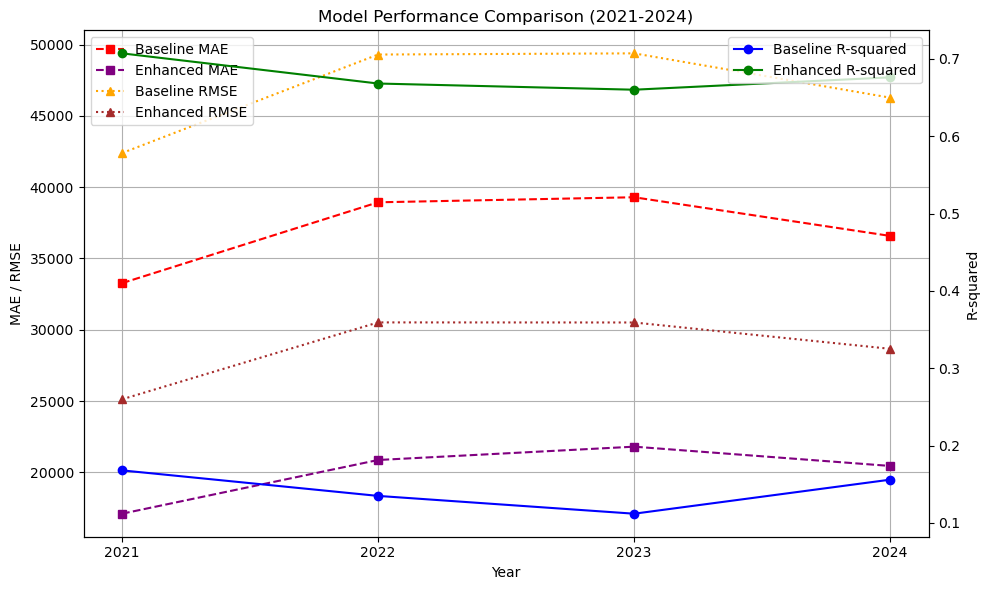

In [1]:
import matplotlib.pyplot as plt

# Data from the table
years = ['2021', '2022', '2023', '2024']
baseline_mae = [33272, 38939, 39293, 36582]
enhanced_mae = [17110, 20875, 21809, 20458]
baseline_rmse = [42392, 49297, 49380, 46273]
enhanced_rmse = [25130, 30520, 30514, 28668]
baseline_r_squared = [0.168, 0.135, 0.112, 0.156]
enhanced_r_squared = [0.707, 0.668, 0.660, 0.676]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MAE and RMSE on the first y-axis
ax1.plot(years, baseline_mae, marker='s', label='Baseline MAE', color='red', linestyle='--')
ax1.plot(years, enhanced_mae, marker='s', label='Enhanced MAE', color='purple', linestyle='--')
ax1.plot(years, baseline_rmse, marker='^', label='Baseline RMSE', color='orange', linestyle=':')
ax1.plot(years, enhanced_rmse, marker='^', label='Enhanced RMSE', color='brown', linestyle=':')

# Labeling for the first y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('MAE / RMSE')
ax1.grid(True)

# Creating a second y-axis for R-squared
ax2 = ax1.twinx()
ax2.plot(years, baseline_r_squared, marker='o', label='Baseline R-squared', color='blue', linestyle='-')
ax2.plot(years, enhanced_r_squared, marker='o', label='Enhanced R-squared', color='green', linestyle='-')

# Labeling for the second y-axis
ax2.set_ylabel('R-squared')

# Adding title and legend
plt.title('Model Performance Comparison (2021-2024)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout and saving the plot
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('performance_comparison.png', format='png')

# Optional: Display the plot
plt.show()


### comparing countries tpr

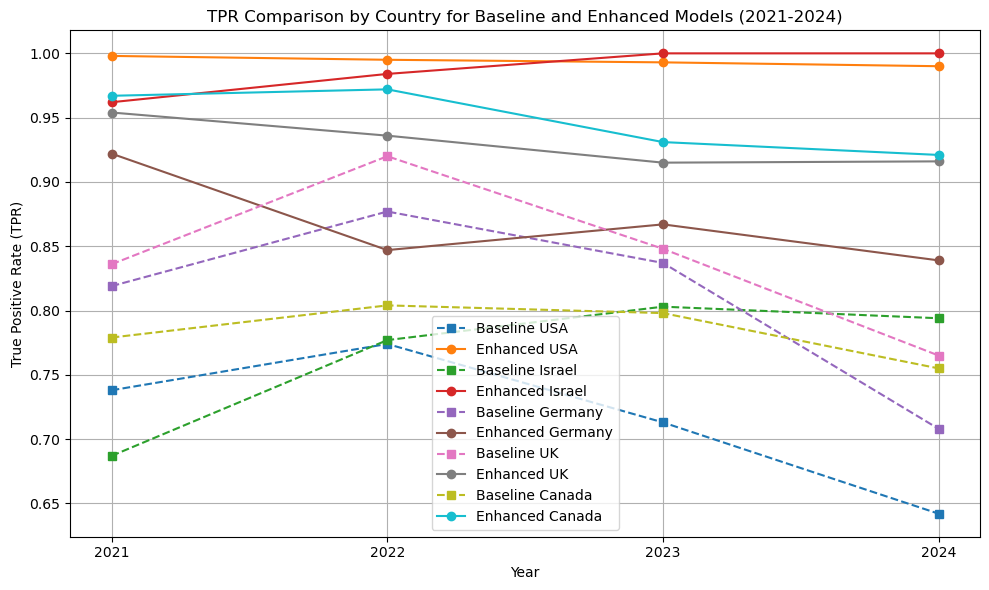

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
years = ['2021', '2022', '2023', '2024']
countries = ['USA', 'Israel', 'Germany', 'UK', 'Canada']
baseline_tpr = {
    'USA': [0.738, 0.774, 0.713, 0.642],
    'Israel': [0.687, 0.777, 0.803, 0.794],
    'Germany': [0.819, 0.877, 0.837, 0.708],
    'UK': [0.836, 0.920, 0.848, 0.765],
    'Canada': [0.779, 0.804, 0.798, 0.755]
}
enhanced_tpr = {
    'USA': [0.998, 0.995, 0.993, 0.990],
    'Israel': [0.962, 0.984, 1.000, 1.000],
    'Germany': [0.922, 0.847, 0.867, 0.839],
    'UK': [0.954, 0.936, 0.915, 0.916],
    'Canada': [0.967, 0.972, 0.931, 0.921]
}

# Plotting the data
plt.figure(figsize=(10, 6))

# Loop through each country to plot the data
for country in countries:
    plt.plot(years, baseline_tpr[country], marker='s', label=f'Baseline {country}', linestyle='--')
    plt.plot(years, enhanced_tpr[country], marker='o', label=f'Enhanced {country}', linestyle='-')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR Comparison by Country for Baseline and Enhanced Models (2021-2024)')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('tpr_comparison.png', format='png')

# Optional: Display the plot
plt.show()


### comparing educations tpr

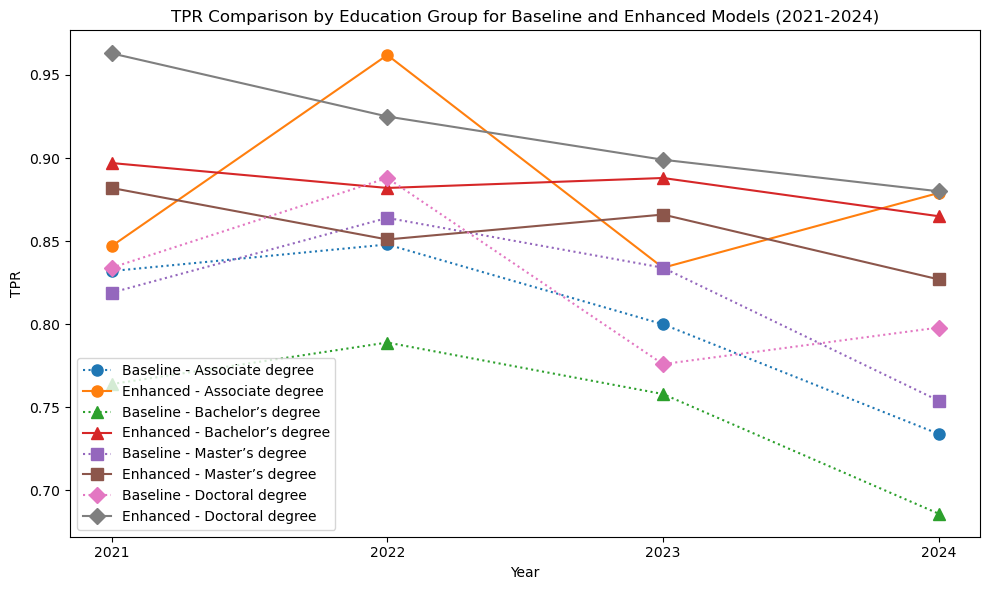

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
years = ['2021', '2022', '2023', '2024']
education_groups = ['Associate degree', 'Bachelor’s degree', 'Master’s degree', 'Doctoral degree']

baseline = {
    '2021': [0.832, 0.764, 0.819, 0.834],
    '2022': [0.848, 0.789, 0.864, 0.888],
    '2023': [0.800, 0.758, 0.834, 0.776],
    '2024': [0.734, 0.686, 0.754, 0.798]
}

enhanced = {
    '2021': [0.847, 0.897, 0.882, 0.963],
    '2022': [0.962, 0.882, 0.851, 0.925],
    '2023': [0.834, 0.888, 0.866, 0.899],
    '2024': [0.879, 0.865, 0.827, 0.880]
}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define X position for each education group
x_pos = np.arange(len(education_groups))

# Markers and line styles
markers = ['o', '^', 's', 'D']  # Circle, Triangle, Square, Diamond
line_styles = ['-', ':']  # Solid for Enhanced, Dotted for Baseline

# Plot the lines for each education group
for i, edu_group in enumerate(education_groups):
    # Baseline model - dotted line
    ax.plot(years, [baseline[year][i] for year in years], label=f'Baseline - {edu_group}', 
            marker=markers[i], linestyle=':', markersize=8)
    
    # Enhanced model - solid line
    ax.plot(years, [enhanced[year][i] for year in years], label=f'Enhanced - {edu_group}', 
            marker=markers[i], linestyle='-', markersize=8)

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('TPR')
ax.set_title('TPR Comparison by Education Group for Baseline and Enhanced Models (2021-2024)')

# Add a legend
ax.legend()

# Save the plot as PNG
plt.tight_layout()
plt.savefig('tpr_comparison_education_group_custom.png', format='png')

# Show the plot
plt.show()
